In [1]:
import sys
import os
import pandas as pd

path = os.path.abspath('../..')
if path not in sys.path:
    sys.path.insert(0, path)
    
sys.path

from primer3plus.utils import reverse_complement as rc
import primer3
from aqbt.contrib.uwbf import primer_utils
from aqbt import AquariumBuildTools
aqtools = AquariumBuildTools.from_toml('creds.secret.toml')
aqtools.sessions

aq = aqtools.sessions['production']['aquarium']

In [3]:
from pydent import Planner

def from_template(template):
    template = Planner(template.session, plan_id=template.id)
    planner = template.copy()
    planner.plan.status = 'planning'
    return planner


In [4]:
fragment_names = ['HIS-HIS<7XTetO-pMinCyc1-URGR-W8>',
 'URA-URA<pGRR-W10W8-URGR-W5>',
 'ARS314-bleo<pGRR-W5W5-URGR-W20>',
 'LEU-LEU<pGRR-W5W5-URGR-W36>',
 'URA-URA<pGRR-W20W36-yeGFP>',
 'ARS314-bleo<pGRR-W10W8-URGR-W5>',
 'TRP-TRP<pGRR-W5W5-URGR-W20>',
 'HIS-HIS<7XTetO-pMinCyc1-URGR-W34>',
 'URA-URA<pGRR-W8W34-URGR-W17>',
 'ARS314-bleo<pGRR-W17W17-URGR-W10>',
 'LEU-LEU<pGRR-W17W17-URGR-W20>',
 'URA-URA<pGRR-W10W20-yeGFP>',
 'ARS314-bleo<pGRR-W8W34-URGR-W17>',
 'TRP-TRP<pGRR-W17W17-URGR-W10>',
 'ARS314-bleo<pGRR-W10W8-URGR-W36>',
 'URA-URA<pGRR-W5W36-yeGFP>',
 'TRP-TRP<pGRR-W10W8-URGR-W36>',
 'URA-URA<pGRR-W8W34-URGR-W10>',
 'URA-URA<pGRR-W10W17-yeGFP>',
 'ARS314-bleo<pGRR-W8W34-URGR-W10>',
 'TRP-TRP<pGRR-W8W34-URGR-W17>',
 'HIS-HIS<7XTetO-pMinCyc1-URGR-W5>',
 'URA-URA<pGRR-W36W5-yeGFP>',
 'URA-URA<pGRR-W17W34-yeGFP>',
 'URA-URA<pGRR-W5W8-URGR-W36>',
 'URA-URA<pGRR-W36W36-yeGFP>',
 'ARS314-bleo<pGRR-W5W8-URGR-W36>',
 'URA-URA<pGRR-W17W17-yeGFP>']

In [59]:
from tqdm.auto import tqdm 
from pydent import Planner
from itertools import zip_longest

    
def grouper(iterable, n, fillvalue=...):
    args = [iter(iterable)] * n
    for x in zip_longest(*args, fillvalue=fillvalue):
        if fillvalue is not ...:
            yield x
        else:
            yield tuple([_x for _x in x if _x is not ...])


def from_template(template):
    template = Planner(template)
    planner = template.copy()
    planner.plan.status = 'planning'
    return planner

def submit_oe(session, sample):
    template = session.Plan.where({'name': '(SD2) Overlap Extension PCR Template', 'status': 'template'})[0]

    planner = from_template(template)

    op = planner.get_op_by_name('Stitch by Overlap Extension')[0]
    op.set_field_value_array('Fragment Mix', 'input', [{'sample': s} for s in sample.properties['Fragment Mix Array']])
    planner.set_field_value_and_propogate(op.outputs[0], sample=sample)
    op = planner.get_op_by_name('Make PCR Fragment')[0]
    planner.set_field_value_and_propogate(op.outputs[0], sample=sample)
    planner.set_inputs_using_sample_properties(op, sample=sample)
    planner.set_field_value(op.input('Template'), object_type=aq.ObjectType.find_by_name('Unverified Fragment PCR Fragment'))
    planner.plan.name = 'OE Ext {}'.format(sample.name)
    return planner

sample = aq.Sample.find_by_name('URA-URA<pGRR-W17W17-yeGFP>')

with aq.with_cache() as session:
    planners = []
    for s in tqdm(fragment_names):
        fragment = aq.Sample.find_by_name(s)
        planners.append(submit_oe(session, fragment))
        
grouper(planners, 10)

  0%|          | 0/28 [00:00<?, ?it/s]

<generator object grouper at 0x7f5e33c44e40>

In [72]:
from typing import *
from pydent.models import Plan
from matplotlib import pylab as plt


def combine(plans: List[Plan]) -> "Planner":
    """Merges a list of plans into a single plan by combining operations
    and wires.

    :param plans: list of Aquarium Plans instances
    :return: new Plan
    """
    copied_plans = [c.copy() for c in plans]

    sessions = {p.session for p in plans}
#     if len(sessions) > 1:
#         raise PlannerException(
#             "Cannot combine plans, plans must all derive from same session instance"
#         )
    session = sessions.pop()

    new_plan = Planner(session)
    new_plan.plan.operations = []
    for p in copied_plans:
        new_plan.plan.operations += p.plan.operations
        new_plan.plan.wires += p.plan.wires
    return new_plan

groups = list(grouper(planners, 5))
for i, g in enumerate(tqdm(groups)):
    print(g)
    combined = combine(g)
    combined.plan.name = "SD2 Transformation fragments {i}/{l}".format(i=i+1, l=len(groups))
    combined.prettify()
    combined.save()
#     combined.layout.draw()
#     plt.plot()

  0%|          | 0/6 [00:00<?, ?it/s]

(<pydent.planner.planner.Planner object at 0x7f5e341b98e0>, <pydent.planner.planner.Planner object at 0x7f5e340827c0>, <pydent.planner.planner.Planner object at 0x7f5e33def4f0>, <pydent.planner.planner.Planner object at 0x7f5e30a50eb0>, <pydent.planner.planner.Planner object at 0x7f5e302b4400>)
(<pydent.planner.planner.Planner object at 0x7f5e30192880>, <pydent.planner.planner.Planner object at 0x7f5e300e7bb0>, <pydent.planner.planner.Planner object at 0x7f5e2b5068e0>, <pydent.planner.planner.Planner object at 0x7f5e2b2931f0>, <pydent.planner.planner.Planner object at 0x7f5e30ec5310>)
(<pydent.planner.planner.Planner object at 0x7f5e30e73a60>, <pydent.planner.planner.Planner object at 0x7f5e2b263a30>, <pydent.planner.planner.Planner object at 0x7f5e2aea8a90>, <pydent.planner.planner.Planner object at 0x7f5e2a838fa0>, <pydent.planner.planner.Planner object at 0x7f5e2a42f850>)
(<pydent.planner.planner.Planner object at 0x7f5e34217b20>, <pydent.planner.planner.Planner object at 0x7f5e29e3

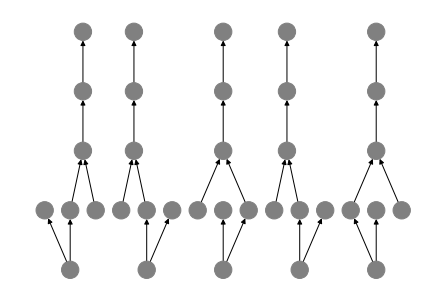

In [70]:
combined.layout.draw()

In [64]:
combined.prettify()
combined.layout.draw()

KeyboardInterrupt: 

In [12]:
from pydent import Planner

def copy_planner(planner):
    new = planner

def from_template(template):
    template = Planner(template)
    planner = template.copy()
    planner.plan.status = 'planning'
    return planner

template = aq.Plan.where({'name': '(SD2) Overlap Extension PCR Template', 'status': 'template'})[0]

planner = from_template(template)

print(id(aq))
print(id(planner.session))
print(id(planner.plan.session))
print(id(planner.plan.operations[0].session))
print(id(planner.plan.operations[1].session))

140042580216752
140042575908192
140042575275680
140042575275680
140042575275680


In [56]:
from pydent.base import ModelBase

t = template.copy()

from copy import deepcopy
memo = {id(template.session): template.session}
c = deepcopy(template, memo)
print(id(c.session))
print(id(template.session))



def copy_aq_model(self, keep: bool = None) -> "ModelBase":
    """Provides a deepcopy of the model, but anonymizes the primary and
    global keys unless class is a metatype (e.g. OperationType, SampleType,
    FieldType) or class name is found in list of 'keep'.

    By default, inventory classes such as Sample, Item, and Collection are 'kept'.

    This specific usecase is that when copying whole plans, that the integrity of
    the inventory used in the operations is maintained. These are the items that
    refer to physical inventory in the laboratory and are referred to by their
    `rids`, and
    so it is important to that any of these inventory are always maintain their
    `rids`.
    Meaning in the lab, their is only ONE instance of the inventory. In Trident
    and Aquarium, there is only ONE instance of inventory that is referred to by
    its rid.

    Similarly, any metatype model must also maintain their `rid`.

    :param keep: list of model classes (as a list of strings) to keep un-anonymous
    :return: copied model
    """
    memo = {id(self.session): self.session}
    copied = deepcopy(self, memo)
    if keep is None:
        keep = self.DEFAULT_COPY_KEEP_UNANONYMOUS

    for m in memo.values():
        if issubclass(type(m), ModelBase):
            if keep is None or m.__class__.__name__ not in keep:
                m.anonymize()
            m._anonymize_field_keys(keep=keep)
    return copied

# ModelBase.copy = copy_aq_model
template = aq.Plan.where({'name': '(SD2) Overlap Extension PCR Template', 'status': 'template'})[0]
# Planner.combine([from_template(template), from_template(template)])

from_template(template).copy()

140042580216752
140042580216752


In [ ]:
AqSession

In [39]:
id(template.session) in memo
list(memo.items())[0]

(140042577802432, <pydent.models.plan.Plan at 0x7f5e33d16e40>)

In [146]:

def grouper(iterable, n, fillvalue=...):
    args = [iter(iterable)] * n
    for x in zip_longest(*args, fillvalue=fillvalue):
        if fillvalue is not ...:
            yield x
        else:
            yield tuple([_x for _x in x if _x is not ...])

        
for _planners in list(grouper(planners, 3)):
    p = Planner.combine(_planners)

PlannerException: Cannot combine plans, plans must all derive from same session instance

In [ ]:
def submit_overlap_extension_pcrs(samples, max_plan_size=10)

In [52]:
from itertools import zip_longest

def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

list(grouper(planners, 3))

NameError: name 'planners' is not defined

In [109]:
template = aq.Plan.where({'name': '(SD2) Overlap Extension PCR Template', 'status': 'template'})[0]

Planner(aq).combine([Planner(template), Planner(template)])

In [110]:
Planner(template) + Planner(template)

In [78]:
from pprint import pprint

def parse_fv(i):
    data = {
        'name': i.name,
        'sample': None,
        'item': None,
        'value': None
    }
    if i.sample:
        data['sample'] = i.sample.name
    else:
        data['value'] = i.value
    if i.item:
        data['item'] = i.item.id
    return data

def parse_op(op):
    data = {
        'operation_type': op.operation_type.name,
        'inputs': [parse_fv(fv) for fv in op.inputs],
        'outputs': [parse_fv(fv) for fv in op.outputs],
        'id': op.id
    }
    return data

def parse_plan(plan):
    data = {
        'operations': [parse_op(op) for op in plan.operations],
        'id': plan.id,
        'name': plan.name
    }
    return data
pprint(parse_plan(planner.plan))

{'id': None,
 'name': '(SD2) Overlap Extension PCR Template',
 'operations': [{'id': None,
                 'inputs': [{'item': None,
                             'name': 'Fragment Mix',
                             'sample': '(SD2) pp2-pGRR-W17',
                             'value': None},
                            {'item': None,
                             'name': 'Overlap Annealing Temperature',
                             'sample': None,
                             'value': '50'},
                            {'item': None,
                             'name': 'Fragment Mix',
                             'sample': '(SD2) W17W17-pGRR-ps',
                             'value': None},
                            {'item': None,
                             'name': 'Fragment Mix',
                             'sample': 'PS-yeGFP-tCyc1-TS',
                             'value': None},
                            {'item': None,
                             'name': 'Fragment Mix',
   

In [69]:
for i in op.inputs:
    data = {
        'name': i.name,
        'sample': None,
        'value': None
    }
    if i.sample:
        data['sample'] = i.sample.name
    else:
        data['value'] = i.value


{'parent_class': 'Operation',
 'value': None,
 'id': None,
 'parent_id': None,
 'child_item_id': None,
 'row': None,
 'name': 'Gel',
 'field_type_id': 108,
 'column': None,
 'child_sample_id': None,
 'allowable_field_type_id': 86,
 'rid': 51121,
 'updated_at': None,
 'created_at': None,
 'role': 'input',
 'child_sample_name': None,
 'sid': None}